<h1>IMPORTING LIBRARIES</h1>

In [14]:
import numpy as np 
from pycuda import compiler, gpuarray, tools
import pycuda.driver as cuda
import pycuda.autoinit
import pandas as pd 
import time
import matplotlib.pyplot as plt
import pycuda.gpuarray as gpuarray
import skcuda.linalg as linalg
import pycuda.autoinit
import cupy as cp



<h1> PyCuda Library </h1>

In [15]:
# DEFINING VARIABLES
MATRIX_SIZE = 1024
BLOCK_SIZE = 32

# create two square matrices
a_cpu = 4*np.ones((MATRIX_SIZE, MATRIX_SIZE)).astype(np.float32)
b_cpu = 5*np.ones((MATRIX_SIZE, MATRIX_SIZE)).astype(np.float32)
c_cpu = np.empty_like(a_cpu)

# STORING THE START TIME 
start= time.time()

# THE RAW CUDA CODE TO MULTIPLY 2 MATRICES
kernel_code_template = """

__global__ void matrixmulti(int matrixsize,float *a, float *b, float *c)
{
    // 2D Thread ID 
    int tx = blockDim.x*blockIdx.x + threadIdx.x; // Compute column index
    int ty = blockDim.y*blockIdx.y + threadIdx.y; // Compute row index
    // Each thread loads one row of M and one column of N, 
    //   to produce one element of P.
    if((ty <matrixsize) && (tx < matrixsize))
    {
    // Pvalue is used to store the element of the matrix
    // that is computed by the thread
    float Pvalue = 0;
    for(int k=0; k<matrixsize;++k)
    {
    float Aelement = a[ty*matrixsize +k];
    float Belement = b[k*matrixsize +tx];
    Pvalue += Aelement * Belement;
    }
    c[ty * matrixsize + tx] = Pvalue;
    }
}
"""

# transfer host (CPU) memory to device (GPU) memory
a_gpu = gpuarray.to_gpu(a_cpu)
b_gpu = gpuarray.to_gpu(b_cpu)
c_gpu = gpuarray.to_gpu(c_cpu)

# compile the kernel code
mod = compiler.SourceModule(kernel_code_template)

# get the kernel function from the compiled module
matrixmul = mod.get_function("matrixmulti")

# set grid size
if MATRIX_SIZE%BLOCK_SIZE != 0:
    grid=(MATRIX_SIZE//BLOCK_SIZE+1,MATRIX_SIZE//BLOCK_SIZE+1,1)
else:
    grid=(MATRIX_SIZE//BLOCK_SIZE,MATRIX_SIZE//BLOCK_SIZE,1)

matrixsize=MATRIX_SIZE

# call the kernel on the 2 previously initialized matrices
matrixmul(np.uint32(matrixsize),
    # inputs
    a_gpu, b_gpu,
    # output
    c_gpu,
    grid=grid,
    block = (BLOCK_SIZE, BLOCK_SIZE, 1),
    )

#printing the final C matrix
# print(c_gpu)

print("The times in multiplying 2 1024x1024 matrices using PyCuda are given below," )
print("TIME ON GPU: " + str(time.time() - start))

# MULTIPLYING THEM ON CPU
startt = time.time()
c_cpu = np.dot(a_cpu,b_cpu)
print("TIME ON CPU: " + str(time.time() - startt))

The times in multiplying 2 1024x1024 matrices using PyCuda are given below,
TIME ON GPU: 0.007400035858154297
TIME ON CPU: 0.20450091361999512


<h1>SkCuda Library</h1>

In [16]:
#INITIALIZING THE PACKAGE
linalg.init()

#INITIALIZING VARIABLES
MATRIX_SIZE = 1000
A = 4*np.ones((MATRIX_SIZE, MATRIX_SIZE)).astype(np.float32)
B = 5*np.ones((MATRIX_SIZE, MATRIX_SIZE)).astype(np.float32)

g_time = time.time()

#TRANSFERRING THE ARRAYS TO GPU
A_gpu = gpuarray.to_gpu(A)
B_gpu = gpuarray.to_gpu(B)

# MATRIX MULTIPLICATION IN GPU
C_gpu = linalg.dot(A_gpu, B_gpu)
e_time = time.time()

print("The times in multiplying 2 1024x1024 matrices using SkCuda are given below," )

print("GPU time(seconds) : " + str(e_time - g_time))
c_time = time.time()
c_cpu = np.dot(a_cpu,b_cpu)
print("CPU time(seconds) : " + str(time.time() - c_time))

The times in multiplying 2 1024x1024 matrices using SkCuda are given below,
GPU time(seconds) : 0.00509190559387207
CPU time(seconds) : 0.20234060287475586


<h1>GAUSS SEIDEL ITERATIVE SCHEME</h1> 

In [17]:
# TO PLOT THE SURFACE GRAPH
def surface_plotter(temp_array,delta_x,delta_y):
    m = temp_array.shape[0]
    n = temp_array.shape[1]
    x = np.zeros_like(temp_array)
    y = np.zeros_like(temp_array)
    
    for i in range(1,n):
        x[:,i] = x[:,i-1] + delta_x
    for i in range(1,m):
        y[i,:] = y[i-1,:] + delta_y
    
    # Creating figure 
    fig = plt.figure(figsize =(20, 15)) 
    ax = plt.axes(projection ='3d') 

    # Creating color map 
    my_cmap = plt.get_cmap('hot') 

    # Creating plot 
    surf = ax.plot_surface(x, y, temp_array, 
                           cmap = my_cmap, 
                           edgecolor ='none') 

    fig.colorbar(surf, ax = ax, 
                 shrink = 0.5, aspect = 5) 

    ax.set_title('Surface plot') 
    ax.set_xlim([0,delta_x*m])
    ax.set_ylim([0,delta_y*n])
    ax.set_zlim([0,np.max(temp_array)])
    ax.set_zlabel("TEMP")
    ax.set_xlabel("Length ")
    ax.set_ylabel("Length ")
    # show plot 
    plt.show() 
    
    

In [18]:
# RUNNING GAUSS SEIDAL ON GPU
def GAUSS_SEIDAL_GPU(len1, len2, t1,t2,t3,t4,iterations,part_x,part_y):
    delta_x = len1/part_x
    delta_y = len2/part_y
    beta = delta_x/delta_y
    start = time.time()
  
    temp_array = cp.zeros((part_y + 1, part_x + 1))
    next_array = cp.zeros((part_y + 1, part_x + 1))

    # INITIALIZE ALL BC
    
    temp_array[part_y,:] = t3
    temp_array[0,:] = t1
    temp_array[:,0] = t4
    temp_array[:,part_x] = t2
    
    next_array[part_y,:] = t3
    next_array[0,:] = t1
    next_array[:,0] = t4
    next_array[:,part_x] = t2
    flag = 1
    for iter in range(iterations):
        if flag == 1:
            for i in range(1,part_x):
                next_array[1:part_y,i] = (temp_array[1:part_y,i+1] + temp_array[1:part_y,i-1])/(2*(1 + (beta**2)))
            for j in range(1,part_y):
                next_array[j,1:part_x] += (temp_array[j+1,1:part_x] + temp_array[j-1,1:part_x])*beta*beta/(2*(1 + (beta**2)))
            flag = 0
 
        else: 
            for i in range(1,part_x):
                temp_array[1:part_y,i] = (next_array[1:part_y,i+1] + next_array[1:part_y,i-1])/(2*(1 + (beta**2)))
            for j in range(1,part_y):
                temp_array[j,1:part_x] += (next_array[j+1,1:part_x] + next_array[j-1,1:part_x])*beta*beta/(2*(1 + (beta**2)))
            flag = 1
    print(time.time() - start)
    if flag == 0:
        return next_array
    return temp_array

In [21]:
# RUNNING GAUSS SEIDAL ON GPU WITH cuPy
def GAUSS_SEIDAL_CPU(len1, len2, t1,t2,t3,t4,iterations,part_x,part_y):
    delta_x = len1/part_x
    delta_y = len2/part_y
    beta = delta_x/delta_y

    start = time.time()
    
    temp_array = np.zeros((part_y + 1, part_x + 1))
    next_array = np.zeros((part_y + 1, part_x + 1))
# INITIALIZE ALL BC
    temp_array[part_x,:] = t3
    temp_array[0,:] = t1
    temp_array[:,0] = t4
    temp_array[:,part_y] = t2
    
    next_array[part_x,:] = t3
    next_array[0,:] = t1
    next_array[:,0] = t4
    next_array[:,part_y] = t2
    flag = 1
    
    for iter in range(iterations):
        if flag == 1:
            for i in range(1,part_x):
                next_array[1:part_y,i] = (temp_array[1:part_y,i+1] + temp_array[1:part_y,i-1])/(2*(1 + (beta**2)))
            for j in range(1,part_y):
                next_array[j,1:part_x] += (temp_array[j+1,1:part_x] + temp_array[j-1,1:part_x])*beta*beta/(2*(1 + (beta**2)))
            flag = 0
 
        else: 
            for i in range(1,part_x):
                temp_array[1:part_y,i] = (next_array[1:part_y,i+1] + next_array[1:part_y,i-1])/(2*(1 + (beta**2)))
            for j in range(1,part_y):
                temp_array[j,1:part_x] += (next_array[j+1,1:part_x] + next_array[j-1,1:part_x])*beta*beta/(2*(1 + (beta**2)))
            flag = 1
    print(time.time() - start)
    if flag == 0:
        return next_array
    return temp_array

The time taken to run the GAUSS SEIDAL ALGORITHM on CPU is 
12.180933237075806


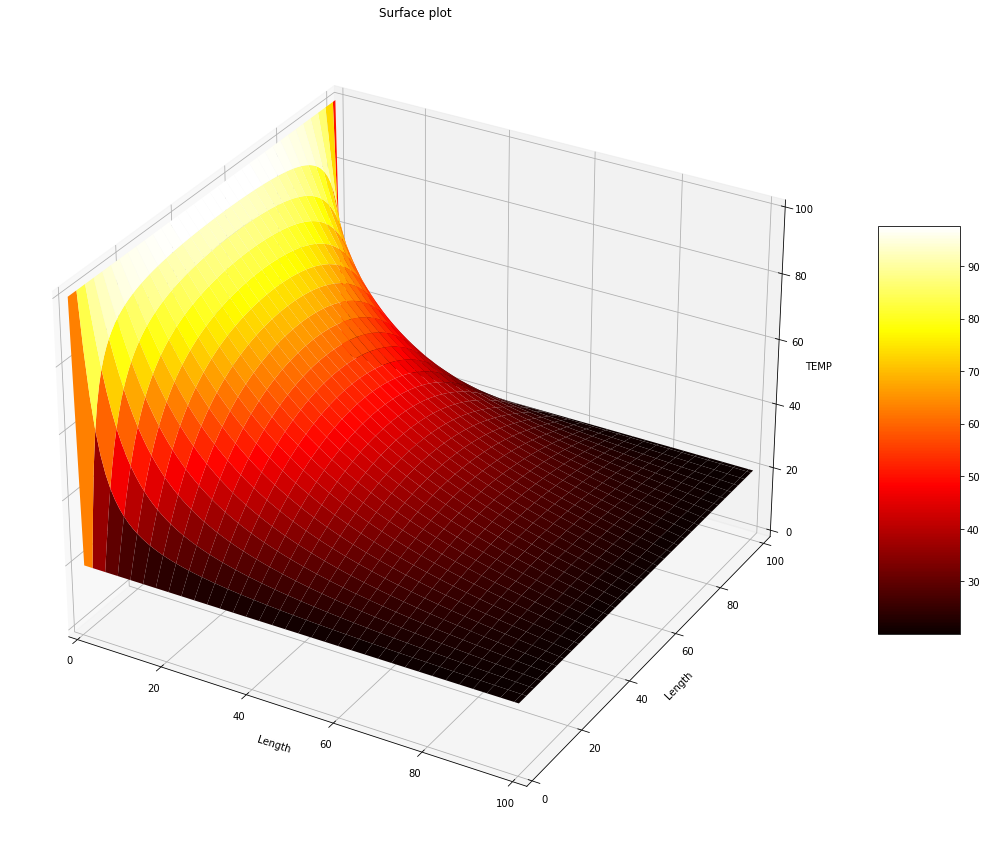

In [23]:
print("The time taken to run the GAUSS SEIDAL ALGORITHM on CPU is ")
surface_plotter(GAUSS_SEIDAL_CPU(100,100,20,20,20,100,10000,100,100),1,1)


The time taken to run the GAUSS SEIDAL ALGORITHM on GPU is 
150.53561162948608


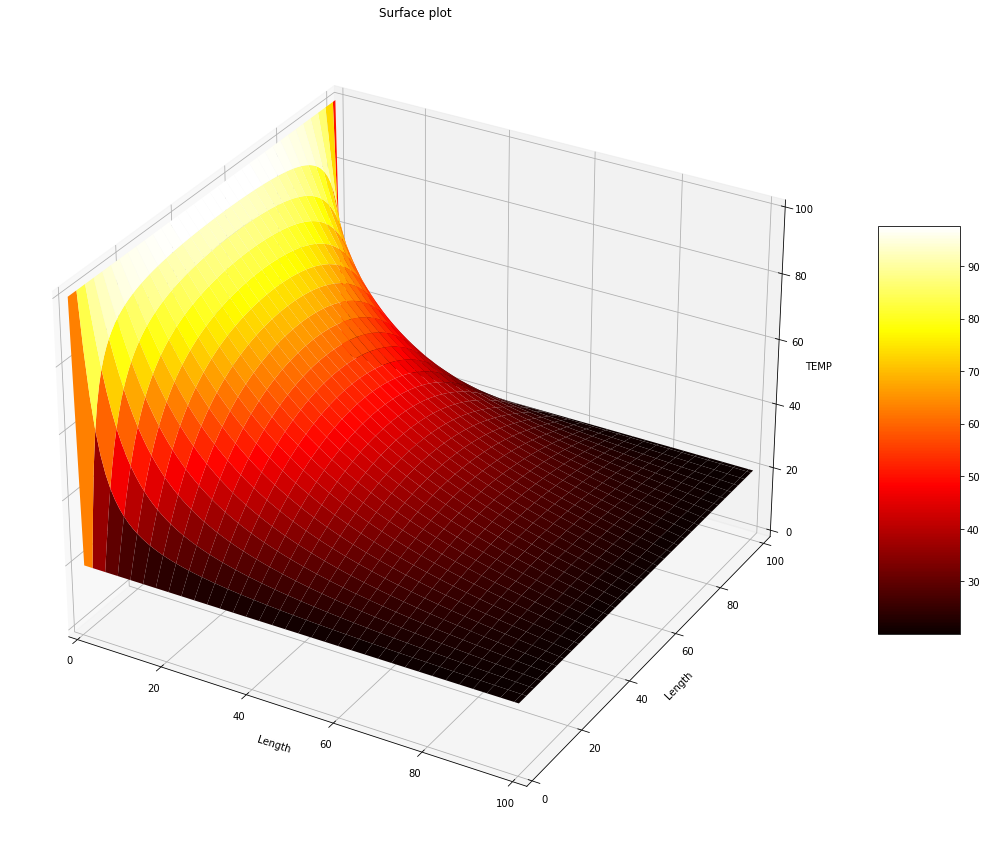

In [24]:
print("The time taken to run the GAUSS SEIDAL ALGORITHM on GPU is ")
surface_plotter(GAUSS_SEIDAL_GPU(100,100,20,20,20,100,10000,100,100).get(),1,1)


<p>We can see that the time taken for CPU is lower than that of GPU, the reason being the calculations are small so the time for the transfer of arrays between CPU and GPU supercedes the actual calculation time</p>

In [26]:
def time_diff(matrix_size,seed):
    
    cp.random.seed(seed)
    start_gpu = time.time()
    x_gpu = cp.random.rand(matrix_size,matrix_size)
    y_gpu = cp.random.rand(matrix_size,matrix_size)
    z_gpu = cp.dot(x_gpu,y_gpu)
    net_gpu = time.time() - start_gpu
    
    np.random.seed(seed)
    start_cpu = time.time()
    x_cpu = np.random.rand(matrix_size,matrix_size)
    y_cpu = np.random.rand(matrix_size,matrix_size)
    z_cpu = np.dot(x_cpu,y_cpu)
    net_cpu = time.time() - start_cpu
    

    return (net_cpu - net_gpu)
print("CPU_TIME - GPU_TIME = "+ str(time_diff(500,1)) + " for mulptiplying 2 arrays of size (500x500)")
print("CPU_TIME - GPU_TIME = "+ str(time_diff(1000,1)) + " for mulptiplying 2 arrays of size (1000x1000)")
print("CPU_TIME - GPU_TIME = "+ str(time_diff(1500,1)) + " for mulptiplying 2 arrays of size (1500x1500)")
print("CPU_TIME - GPU_TIME = "+ str(time_diff(2000,1)) + " for mulptiplying 2 arrays of size (2000x2000)")
print("CPU_TIME - GPU_TIME = "+ str(time_diff(2500,1)) + " for mulptiplying 2 arrays of size (2500x2500)")
print("CPU_TIME - GPU_TIME = "+ str(time_diff(3000,1)) + " for mulptiplying 2 arrays of size (3000x3000)")

CPU_TIME - GPU_TIME = 0.08922100067138672 for mulptiplying 2 arrays of size (500x500)
CPU_TIME - GPU_TIME = 0.7385287284851074 for mulptiplying 2 arrays of size (1000x1000)
CPU_TIME - GPU_TIME = 1.8229022026062012 for mulptiplying 2 arrays of size (1500x1500)
CPU_TIME - GPU_TIME = 3.859034299850464 for mulptiplying 2 arrays of size (2000x2000)
CPU_TIME - GPU_TIME = 10.003085613250732 for mulptiplying 2 arrays of size (2500x2500)
CPU_TIME - GPU_TIME = 18.97449803352356 for mulptiplying 2 arrays of size (3000x3000)


<p>We observe that the difference in time increases as the size of array increases, which is expected as the actual calculation time starts to overtake.</p>

In [28]:
print("CPU Time(s): ")
GAUSS_SEIDAL_CPU(5000,5000,20,20,20,100,100,5000,5000)
print("GPU Time(s): ")
GAUSS_SEIDAL_GPU(5000,5000,20,20,20,100,100,5000,5000)
print("We now run the same GAUSS SEIDAL code but with larger number of calculations and now we see that GPU runs faster than CPU.")

CPU Time(s): 
94.33543109893799
GPU Time(s): 
75.7463493347168
We now run the same GAUSS SEIDAL code but with larger number of calculations and now we see that GPU runs faster than CPU.
